In [6]:
versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: AMD Ryzen 5 3600 6-Core Processor              
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, znver1)


In [4]:
include("../src/cheby_sampler_dw.jl")
include("../src/ssor_sampler_dw.jl")
include("../src/data_generation.jl")
using BenchmarkTools, IterativeSolvers, Random, LinearAlgebra, SparseArrays, DataFrames

In [5]:
# expectaion and variance_container
# we calculate the sample mean and sample variance accumulatively
mutable struct Sample_moment
    # to estimate S^(k) of k-th iteration 
    S::Array{Float64, 2}
    μ::Vector{Float64}
    y::Vector{Float64}
end

In [7]:
Random.seed!(111)
n = 10
A = gen_A(n)
b = randn(n^2)
Ainv = inv(Matrix(A))
nsample = 10000
maxiter = 220

#intial declare
moments = Sample_moment(zeros(n^2, n^2), zeros(n^2), zeros(n^2))

Sample_moment([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
# Cheby-accelerated Gibbs sampler with w = 1.0
# 1:1:220 의 iteration에 대해 계산함
iterationgrid = collect(1:1:maxiter);  # x-axis of the plot
w = 1.0
λ_max,λ_min = eigMm(A, w)
errorpath = zeros(length(iterationgrid)) # relative error between Ainv and S^(k)

@time for i in iterationgrid
    moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
    # taking 10,000 samples
    @time for j in 1:nsample
        if j%2500 == 0
            println(i, "-th iteration; ", j, "-th sample")
        end
        moments.y = k3_CB_ssor_sp(A, copy(b), w, λ_max, λ_min, i)
        moments.S += moments.y * moments.y'
        moments.μ += moments.y
    end
    moments.S /= nsample
    moments.μ /= nsample
    moments.S -= moments.μ * moments.μ'
    errorpath[i] = norm(Ainv - moments.S) / norm(Ainv)
end

In [ ]:
using Plots; gr()
plt = Plots.plot(iterationgrid, errorpath, legend=:none, yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "Cheby-ssor sampler with w = 1")
savefig(plt,"plot_cbgibbs_w1_by1.png")

In [8]:
# Cheby-accelerated Gibbs sampler with w = 1.0
# 10:10:220 의 iteration에 대해 계산함
iterationgrid = collect(10:10:maxiter);  # x-axis of the plot
w = 1.0
λ_max,λ_min = eigMm(A, w)
errorpath_lessiter = zeros(length(iterationgrid)) # relative error between Ainv and S^(k)

@time for i in 1:22
    moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
    # taking 10,000 samples
    @time for j in 1:nsample
        if j%2500 == 0
            println(i*10, "-th iteration; ", j, "-th sample")
        end
        moments.y = k3_CB_ssor_sp(A, copy(b), w, λ_max, λ_min, i*10)
        moments.S += moments.y * moments.y'
        moments.μ += moments.y
    end
    moments.S /= nsample
    moments.μ /= nsample
    moments.S -= moments.μ * moments.μ'
    errorpath_lessiter[i] = norm(Ainv - moments.S) / norm(Ainv)
end

10-th iteration; 2500-th sample
10-th iteration; 5000-th sample
10-th iteration; 7500-th sample
10-th iteration; 10000-th sample
  1.487299 seconds (2.33 M allocations: 2.132 GiB, 11.76% gc time)
20-th iteration; 2500-th sample
20-th iteration; 5000-th sample
20-th iteration; 7500-th sample
20-th iteration; 10000-th sample
  1.320927 seconds (887.73 k allocations: 2.220 GiB, 8.67% gc time)
30-th iteration; 2500-th sample
30-th iteration; 5000-th sample
30-th iteration; 7500-th sample
30-th iteration; 10000-th sample
  1.667089 seconds (1.09 M allocations: 2.387 GiB, 6.20% gc time)
40-th iteration; 2500-th sample
40-th iteration; 5000-th sample
40-th iteration; 7500-th sample
40-th iteration; 10000-th sample
  2.114924 seconds (1.29 M allocations: 2.554 GiB, 5.25% gc time)
50-th iteration; 2500-th sample
50-th iteration; 5000-th sample
50-th iteration; 7500-th sample
50-th iteration; 10000-th sample
  2.574545 seconds (1.49 M allocations: 2.721 GiB, 3.91% gc time)
60-th iteration; 2500-

In [5]:
using Plots; gr()
plt = Plots.plot(iterationgrid, errorpath_lessiter, legend=:none, yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "Cheby-ssor sampler with w = 1")
savefig(plt,"plot_cbgibbs_w1_by10.png")

In [9]:
# Cheby-accelerated Gibbs sampler with w = 1.6641
# 1:1:220 의 iteration에 대해 계산함
iterationgrid = collect(1:1:maxiter);  # x-axis of the plot
w = 1.6641
λ_max,λ_min = eigMm(A, w)
errorpath2 = zeros(length(iterationgrid)) # relative error between Ainv and S^(k)

@time for i in 1:maxiter
    moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
    # taking 10,000 samples
    @time for j in 1:nsample
        if j%2500 == 0
            println(i, "-th iteration; ", j, "-th sample")
        end
        moments.y = k3_CB_ssor_sp(A, copy(b), w, λ_max, λ_min, i)
        moments.S += moments.y * moments.y'
        moments.μ += moments.y
    end
    moments.S /= nsample
    moments.μ /= nsample
    moments.S -= moments.μ * moments.μ'
    errorpath2[i] = norm(Ainv - moments.S) / norm(Ainv)
end

1-th iteration; 2500-th sample
1-th iteration; 5000-th sample
1-th iteration; 7500-th sample
1-th iteration; 10000-th sample
  0.527040 seconds (507.64 k allocations: 1.903 GiB, 20.94% gc time)
2-th iteration; 2500-th sample
2-th iteration; 5000-th sample
2-th iteration; 7500-th sample
2-th iteration; 10000-th sample
  0.533623 seconds (527.75 k allocations: 1.920 GiB, 18.42% gc time)
3-th iteration; 2500-th sample
3-th iteration; 5000-th sample
3-th iteration; 7500-th sample
3-th iteration; 10000-th sample
  0.580764 seconds (547.74 k allocations: 1.937 GiB, 17.53% gc time)
4-th iteration; 2500-th sample
4-th iteration; 5000-th sample
4-th iteration; 7500-th sample
4-th iteration; 10000-th sample
  0.599542 seconds (567.75 k allocations: 1.953 GiB, 15.84% gc time)
5-th iteration; 2500-th sample
5-th iteration; 5000-th sample
5-th iteration; 7500-th sample
5-th iteration; 10000-th sample
  0.643885 seconds (587.75 k allocations: 1.970 GiB, 14.64% gc time)
6-th iteration; 2500-th sample

In [10]:
using Plots; gr()
plt = Plots.plot(iterationgrid, errorpath2, legend=:none, yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "Cheby-ssor sampler with w = 1.6641")
savefig(plt,"plot_cbgibbs_w16641_by1.png")

In [11]:
# Cheby-accelerated Gibbs sampler with w = 1.6641
# 10:10:220 의 iteration에 대해 계산함
iterationgrid = collect(10:10:maxiter);  # x-axis of the plot
w = 1.6641
λ_max,λ_min = eigMm(A, w)
errorpath2_lessiter = zeros(length(iterationgrid)) # relative error between Ainv and S^(k)

@time for i in 1:22
    moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
    # taking 10,000 samples
    @time for j in 1:nsample
        if j%2500 == 0
            println(i*10, "-th iteration; ", j, "-th sample")
        end
        moments.y = k3_CB_ssor_sp(A, copy(b), w, λ_max, λ_min, i*10)
        moments.S += moments.y * moments.y'
        moments.μ += moments.y
    end
    moments.S /= nsample
    moments.μ /= nsample
    moments.S -= moments.μ * moments.μ'
    errorpath2_lessiter[i] = norm(Ainv - moments.S) / norm(Ainv)
end

10-th iteration; 2500-th sample
10-th iteration; 5000-th sample
10-th iteration; 7500-th sample
10-th iteration; 10000-th sample
  0.904991 seconds (916.84 k allocations: 2.065 GiB, 13.04% gc time)
20-th iteration; 2500-th sample
20-th iteration; 5000-th sample
20-th iteration; 7500-th sample
20-th iteration; 10000-th sample
  1.256920 seconds (887.76 k allocations: 2.220 GiB, 9.12% gc time)
30-th iteration; 2500-th sample
30-th iteration; 5000-th sample
30-th iteration; 7500-th sample
30-th iteration; 10000-th sample
  1.628842 seconds (1.09 M allocations: 2.387 GiB, 7.33% gc time)
40-th iteration; 2500-th sample
40-th iteration; 5000-th sample
40-th iteration; 7500-th sample
40-th iteration; 10000-th sample
  2.328340 seconds (1.29 M allocations: 2.554 GiB, 5.35% gc time)
50-th iteration; 2500-th sample
50-th iteration; 5000-th sample
50-th iteration; 7500-th sample
50-th iteration; 10000-th sample
  2.620540 seconds (1.49 M allocations: 2.721 GiB, 5.22% gc time)
60-th iteration; 250

In [12]:
using Plots; gr()
plt = Plots.plot(iterationgrid, errorpath2_lessiter, legend=:none,yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "Cheby-ssor sampler with w = 1.6641")
savefig(plt,"plot_cbgibbs_w16641_by10.png")

In [13]:
# SSOR sampler with w = 1.0
# 10:10:220 의 iteration에 대해 계산함
iterationgrid = collect(10:10:maxiter);  # x-axis of the plot
w = 1
errorpath3 = zeros(length(iterationgrid)) # relative error between Ainv and S^(k)

@time for i in 1:22
    moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
    # taking 10,000 samples
    @time for j in 1:nsample
        if j%2500 == 0
            println(i*10, "-th iteration; ", j, "-th sample")
        end
        moments.y = k3_ssor_sp(A, w, i*10)
        moments.S += moments.y * moments.y'
        moments.μ += moments.y
    end
    moments.S /= nsample
    moments.μ /= nsample
    moments.S -= moments.μ * moments.μ'
    errorpath3[i] = norm(Ainv - moments.S) / norm(Ainv)
end

10-th iteration; 2500-th sample
10-th iteration; 5000-th sample
10-th iteration; 7500-th sample
10-th iteration; 10000-th sample
  0.796880 seconds (736.91 k allocations: 1.978 GiB, 15.00% gc time)
20-th iteration; 2500-th sample
20-th iteration; 5000-th sample
20-th iteration; 7500-th sample
20-th iteration; 10000-th sample
  1.098034 seconds (767.79 k allocations: 2.136 GiB, 10.79% gc time)
30-th iteration; 2500-th sample
30-th iteration; 5000-th sample
30-th iteration; 7500-th sample
30-th iteration; 10000-th sample
  1.437554 seconds (967.76 k allocations: 2.303 GiB, 8.70% gc time)
40-th iteration; 2500-th sample
40-th iteration; 5000-th sample
40-th iteration; 7500-th sample
40-th iteration; 10000-th sample
  1.809573 seconds (1.17 M allocations: 2.470 GiB, 7.34% gc time)
50-th iteration; 2500-th sample
50-th iteration; 5000-th sample
50-th iteration; 7500-th sample
50-th iteration; 10000-th sample
  2.177774 seconds (1.37 M allocations: 2.637 GiB, 6.28% gc time)
60-th iteration; 

In [14]:
using Plots; gr()
plt = Plots.plot(iterationgrid, errorpath3, legend=:none, yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "SSOR sampler with w = 1")
savefig(plt,"plot_ssorgibbs_w1_by10.png")

In [15]:
# SSOR sampler with w = 1.6641
# 10:10:220 의 iteration에 대해 계산함
iterationgrid = collect(10:10:maxiter);  # x-axis of the plot
w = 1.6641
errorpath4 = zeros(length(iterationgrid)) # relative error between Ainv and S^(k)

@time for i in 1:22
    moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
    # taking 10,000 samples
    @time for j in 1:nsample
        if j%2500 == 0
            println(i*10, "-th iteration; ", j, "-th sample")
        end
        moments.y = k3_ssor_sp(A, w, i*10)
        moments.S += moments.y * moments.y'
        moments.μ += moments.y
    end
    moments.S /= nsample
    moments.μ /= nsample
    moments.S -= moments.μ * moments.μ'
    errorpath4[i] = norm(Ainv - moments.S) / norm(Ainv)
end

10-th iteration; 2500-th sample
10-th iteration; 5000-th sample
10-th iteration; 7500-th sample
10-th iteration; 10000-th sample
  0.766160 seconds (652.30 k allocations: 1.974 GiB, 15.66% gc time)
20-th iteration; 2500-th sample
20-th iteration; 5000-th sample
20-th iteration; 7500-th sample
20-th iteration; 10000-th sample
  1.099445 seconds (767.74 k allocations: 2.136 GiB, 10.38% gc time)
30-th iteration; 2500-th sample
30-th iteration; 5000-th sample
30-th iteration; 7500-th sample
30-th iteration; 10000-th sample
  1.429537 seconds (967.76 k allocations: 2.303 GiB, 8.40% gc time)
40-th iteration; 2500-th sample
40-th iteration; 5000-th sample
40-th iteration; 7500-th sample
40-th iteration; 10000-th sample
  1.769256 seconds (1.17 M allocations: 2.470 GiB, 7.21% gc time)
50-th iteration; 2500-th sample
50-th iteration; 5000-th sample
50-th iteration; 7500-th sample
50-th iteration; 10000-th sample
  2.186781 seconds (1.37 M allocations: 2.637 GiB, 6.23% gc time)
60-th iteration; 

In [16]:
using Plots; gr()
plt = Plots.plot(iterationgrid, errorpath4, legend=:none,yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "SSOR sampler with w = 1.6641")
savefig(plt,"plot_ssorgibbs_w16641_by10.png")

In [17]:
# cholesky sampler
include("../src/chol.jl")

moments.S, moments.y, moments.μ = zeros(n^2, n^2), zeros(n^2), zeros(n^2)
# taking 10,000 samples
@time for j in 1:nsample
    if j%2500 == 0
        println(j, "-th sample")
    end
    moments.y = choleskySampler(A)
    moments.S += moments.y * moments.y'
    moments.μ += moments.y
end
moments.S /= nsample
moments.μ /= nsample
moments.S -= moments.μ * moments.μ'
cholerror = norm(Ainv - moments.S) / norm(Ainv)

2500-th sample
5000-th sample
7500-th sample
10000-th sample
  3.580297 seconds (3.08 M allocations: 2.839 GiB, 5.59% gc time)


0.0022190796707164794

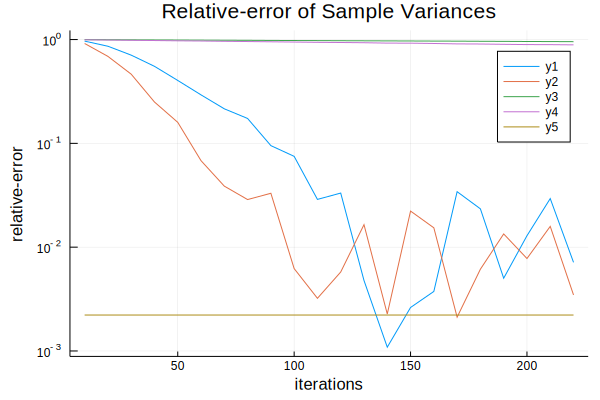

In [18]:
# all combining
using Plots; gr()
iterationgrid = 10:10:220
errorpaths = zeros(22, 5)
errorpaths[:, 1] = errorpath_lessiter  #legend: y1, cheby-ssor with w = 1
errorpaths[:, 2] = errorpath2_lessiter  #legend: y2, cheby-ssor with w = 1.6441
errorpaths[:, 3] = errorpath3  #legend: y3, ssor with w = 1
errorpaths[:, 4] = errorpath4  #legend: y4, ssor with w = 1.6441
errorpaths[:, 5] .= cholerror  #legend: y5, cholesky

plt = Plots.plot(collect(iterationgrid), errorpaths, yscale = :log10)
xlabel!(plt, "iterations")
ylabel!(plt, "relative-error")
title!(plt, "Relative-error of Sample Variances")
#savefig(plt,"figure1.png")